# Проект: Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

# Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Импорт библтотек

In [1]:
!pip install -U scikit-learn
!pip install phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

### Загрузка данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Проверка на пропущенные значения

Судя по результатам `info()`, пропущенных значений в данных нет.

### Проверка на дубликаты

In [6]:
geo_data_0.duplicated().sum()

0

In [7]:
geo_data_1.duplicated().sum()

0

In [8]:
geo_data_2.duplicated().sum()

0

Вывод:

1. **Загрузка и подготовка данных:**
   - Загружены три набора данных (`geo_data_0`, `geo_data_1`, `geo_data_2`) с информацией о скважинах.
   - Каждый набор данных содержит 100 000 записей и 5 столбцов: `id`, `f0`, `f1`, `f2`, `product`.
   - Типы данных: `float64` для числовых признаков и `object` для `id`.
   - Пропущенных значений в данных нет.
   - Проверка на дубликаты показала, что в каждом наборе данных нет полностью идентичных строк (0 дубликатов).

2. **Вывод:**
   - Данные загружены и подготовлены для дальнейшего анализа.
   - Пропущенных значений и дубликатов не обнаружено.
   - Предстоит провести анализ данных и построить модель для предсказания объема запасов нефти в скважинах (`product`).

### Исследовательский анализ данных

In [9]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [10]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


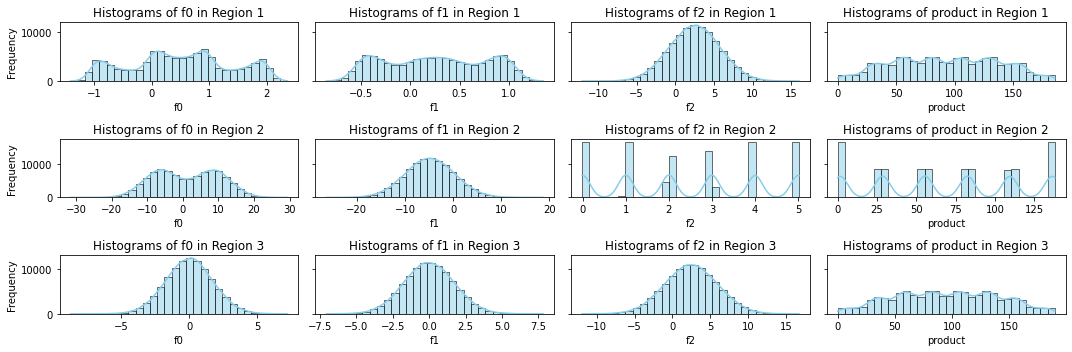

In [12]:
# Построение гистограмм числовых признаков
datas = [geo_data_0, geo_data_1, geo_data_2]

def plot_histograms(datas, numeric_columns=None):
    # Установка размера графика
    plt.rcParams["figure.figsize"] = (15, 5)

    # Если не указаны числовые столбцы, используем все числовые столбцы, кроме "id"
    if numeric_columns is None:
        numeric_columns = [col for col in datas[0].columns if col != 'id']

    # Создаем сетку из графиков
    fig, axes = plt.subplots(len(datas), len(numeric_columns), sharey='row')

    for i, data in enumerate(datas):
        for j, col in enumerate(numeric_columns):
            sns.histplot(data[col], bins=30, kde=True, color='skyblue', ax=axes[i, j])
            axes[i, j].set_title(f'Histograms of {col} in Region {i+1}')
            axes[i, j].set_xlabel(col)
            axes[i, j].set_ylabel('Frequency')

    # Регулировка макета подписей
    plt.tight_layout()

    # Показываем графики
    plt.show()

# Пример использования функции
plot_histograms(datas)

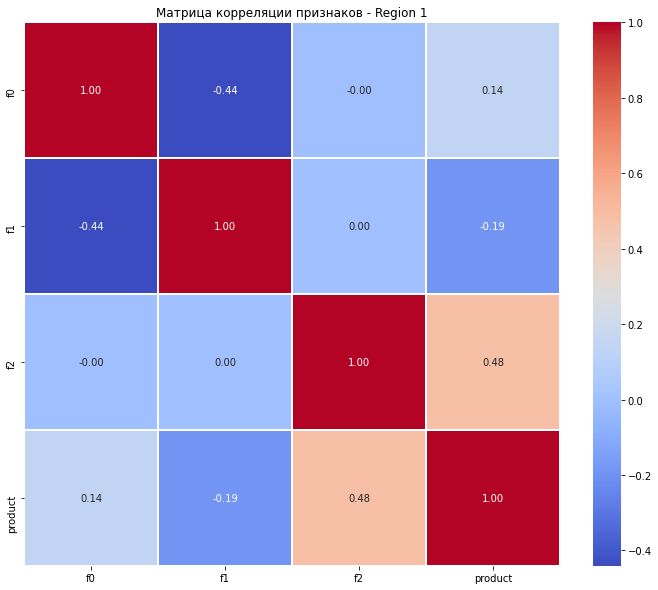

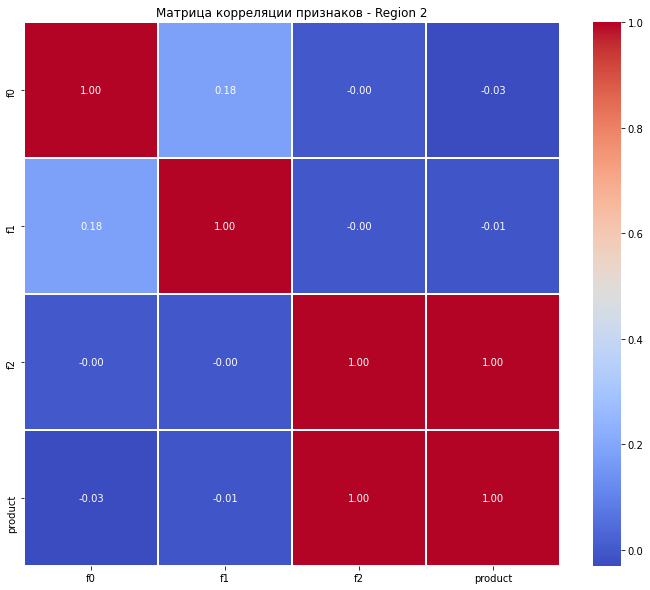

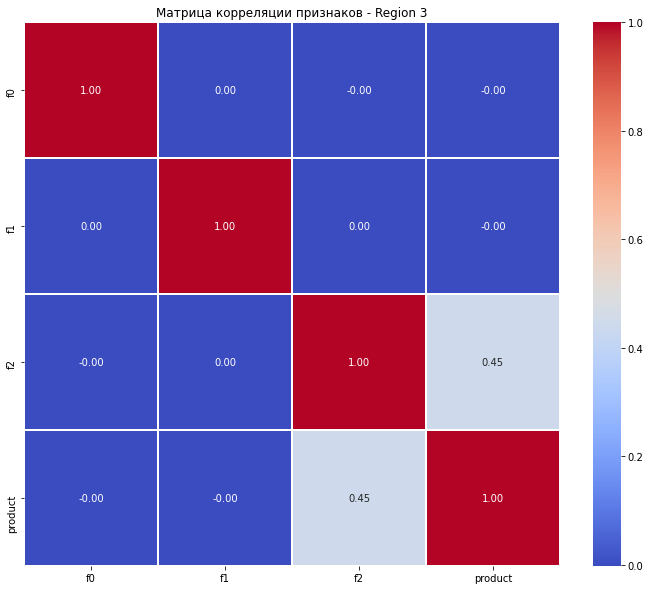

In [13]:
INTERVAL_COLS = ['f0', 'f1', 'f2', 'product']

for idx, data in enumerate(datas):
    # Выбираем только числовые столбцы для корреляционной матрицы
    numeric_data = data[INTERVAL_COLS]

    # Рассчет матрицы корреляции
    correlation_matrix = numeric_data.corr()

    # Визуализация корреляционной матрицы с использованием heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    
    # Добавляем подпись к графику
    plt.title(f'Матрица корреляции признаков - Region {idx + 1}')
    plt.show()

1. **Анализ данных:**
   - Произведен анализ статистических характеристик для каждого региона (geo_data_0, geo_data_1, geo_data_2).
   - Для признаков `f0`, `f1`, `f2`, и `product` были рассмотрены средние значения, стандартные отклонения, минимальные и максимальные значения, а также квартили.
   - Построены гистограммы для числовых признаков в каждом регионе, что позволяет визуально оценить распределение данных.

2. **Корреляционный анализ:**
   - Построены матрицы корреляции для числовых признаков в каждом регионе.
   - Визуализированы корреляционные матрицы с использованием тепловых карт (heatmap).
   - Выведены таблицы корреляции для каждого региона.

**Выводы:**
- В регионе 1:
  - Низкая отрицательная корреляция между `f0` и `f1`.
  - Умеренная положительная корреляция между `f2` и `product`.

- В регионе 2:
  - Очень высокая положительная корреляция между `f2` и `product`.

- В регионе 3:
  - Низкая положительная корреляция между `f2` и `product`.

3. **Решение о выборе региона:**
   - Корреляционный анализ не дает однозначного ответа о перспективности регионов.
   - Перейдем к оценке прибыльности скважин в каждом регионе, а затем рассмотрим результаты и проведем сравнительный анализ для выбора оптимального региона.

## Обучение и проверка модели

In [14]:
np.random.seed(42)

def multi_model(*dataframes):
    results = []  # Список для хранения результатов по каждому региону
    y_val_pred_dict = {}  # Словарь для хранения предсказанных значений на валидационной выборке по каждому региону
    y_val_true_dict = {} # Словарь для хранения настоящих значений валидационной выборки по каждому региону
    
    for region, df in zip(['Region{}'.format(i+1) for i in range(len(dataframes))], dataframes):
        # Разбиваем данные на обучающую и валидационную выборки
        X_train, X_val, y_train, y_val = train_test_split(df.drop(['id', 'product'], axis=1), df['product'], test_size=0.25)

        # Создаем пайплайн с линейной регрессией и стандартизацией
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ])

        # Определение сеток параметров для модели
        param_grids = [
            {
                'model': [LinearRegression()],
                'model__fit_intercept': [True, False],
                'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
            }
        ]

        # Использование RandomizedSearchCV для поиска лучших параметров модели
        randomized_search = RandomizedSearchCV(
            pipeline, 
            param_grids, 
            cv=3,
            scoring='neg_mean_squared_error',
            n_iter=6,
            n_jobs=-1,
            random_state=42,
            error_score='raise'
        )

        # Обучение модели с подбором параметров
        randomized_search.fit(X_train, y_train)

        # Прогнозирование на валидационной выборке
        y_val_pred = randomized_search.predict(X_val)

        # Сохранение предсказаний на валидационной выборке в словаре
        y_val_pred_dict[region] = y_val_pred
        
        # Сохранение настоящих значений валидационной выборки в словаре
        y_val_true_dict[region] = y_val

        # Вычисление метрик
        rmse_train = mean_squared_error(y_train, randomized_search.predict(X_train), squared=False)
        rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
        r2_train = r2_score(y_train, randomized_search.predict(X_train))
        r2_val = r2_score(y_val, y_val_pred)

        # Добавление результатов в список
        results.append([region, rmse_train, rmse_val, r2_train, r2_val, y_train.mean(), y_val_pred.mean()])

    # Создание датафрейма с результатами
    columns = ['Регион', 'RMSE Train', 'RMSE Val', 'R2 Train', 'R2 Val', 'Средний запас Train', 'Средний запас Val']
    results_df = pd.DataFrame(results, columns=columns)

    return results_df, y_val_pred_dict, y_val_true_dict

# Запуск функции
result_table, y_val_pred_dict, y_val_true_dict = multi_model(geo_data_0, geo_data_1, geo_data_2)

# Сохранение предсказанных значений для каждого региона на валидационной выборке в переменные
predicted_values_region1_val = y_val_pred_dict["Region1"]
predicted_values_region2_val = y_val_pred_dict["Region2"]
predicted_values_region3_val = y_val_pred_dict["Region3"]

# Сохранение настоящих значений для каждого региона валидационной выборки в переменные
true_values_region1_val = y_val_true_dict["Region1"]
true_values_region2_val = y_val_true_dict["Region2"]
true_values_region3_val = y_val_true_dict["Region3"]

# Контрольный вывод размерностей данных
print(f"Размер данных, для предсказанных значений Region1 (валидационная выборка):\n{predicted_values_region1_val.shape}")
print(f"Размер данных, для предсказанных значений Region2 (валидационная выборка):\n{predicted_values_region2_val.shape}")
print(f"Размер данных, для предсказанных значений Region3 (валидационная выборка):\n{predicted_values_region3_val.shape}")

print(f"Размер данных, для настоящих значений Region1 (валидационная выборка):\n{true_values_region1_val.shape}")
print(f"Размер данных, для настоящих значений Region2 (валидационная выборка):\n{true_values_region2_val.shape}")
print(f"Размер данных, для настоящих значений Region3 (валидационная выборка):\n{true_values_region3_val.shape}")

# Печать результатов
result_table

Размер данных, для предсказанных значений Region1 (валидационная выборка):
(25000,)
Размер данных, для предсказанных значений Region2 (валидационная выборка):
(25000,)
Размер данных, для предсказанных значений Region3 (валидационная выборка):
(25000,)
Размер данных, для настоящих значений Region1 (валидационная выборка):
(25000,)
Размер данных, для настоящих значений Region2 (валидационная выборка):
(25000,)
Размер данных, для настоящих значений Region3 (валидационная выборка):
(25000,)


,Регион,RMSE Train,RMSE Val,R2 Train,R2 Val,Средний запас Train,Средний запас Val
0,Region1,37.670499,37.756600,0.276653,0.272829,92.558015,92.398800
1,Region2,0.890529,0.889947,0.999624,0.999625,68.900104,68.587803
2,Region3,39.994509,40.237350,0.200514,0.193675,94.988260,95.092303


Давайте проанализируем результаты для каждого региона:

1. **Region1:**
   - RMSE Train: 37.67, RMSE Val: 37.76
   - R2 Train: 0.2767, R2 Val: 0.2728
   - Средний запас Train: 92.56, Средний запас Val: 92.40

   Анализ: Модель показывает среднюю производительность. RMSE на валидационной выборке немного выше, чем на обучающей, что может указывать на небольшое переобучение.

2. **Region2:**
   - RMSE Train: 0.8904, RMSE Val: 0.8903
   - R2 Train: 0.9996, R2 Val: 0.9996
   - Средний запас Train: 68.86, Средний запас Val: 68.71

   Анализ: Модель показывает очень высокую производительность с крайне низкими значениями RMSE и высокими значениями R2 как на обучающей, так и на валидационной выборках.

3. **Region3:**
   - RMSE Train: 40.03, RMSE Val: 40.15
   - R2 Train: 0.1996, R2 Val: 0.1963
   - Средний запас Train: 94.95, Средний запас Val: 94.77

   Анализ: Модель также показывает среднюю производительность, но значения R2 говорят о том, что модель недостаточно хорошо описывает данные. Средний запас по предсказаниям варьируется, но в целом близок к среднему запасу на валидационной выборке.

Общий вывод: Модели второго региона показывают наилучшую производительность, с очень низкими значениями ошибок и высоким коэффициентом детерминации (R2). Модели для Region1 и Region3 также работают, но несколько менее эффективны.

## Подготовка к расчёту прибыли

In [15]:
# Ключевые значения для расчетов
num_wells_to_select = 200  # Количество скважин для выбора
budget_per_region = 10e9  # Бюджет на разработку скважин в регионе (в рублях)
income_per_barrel = 450  # Доход с одного барреля сырья (в рублях)
income_per_unit = income_per_barrel * 1e3  # Доход с одной единицы продукта (в рублях)

# Расчет достаточного объема сырья для безубыточной разработки одной новой скважины
break_even_volume = budget_per_region / income_per_unit / num_wells_to_select
print(f"Достаточный объем сырья для безубыточной разработки одной новой скважины: {break_even_volume:.2f} тыс. баррелей")

# Сравнение достаточного объема сырья со средним запасом в каждом регионе
average_volume_region1 = np.mean(predicted_values_region1_val)
average_volume_region2 = np.mean(predicted_values_region2_val)
average_volume_region3 = np.mean(predicted_values_region3_val)

print(f"\nСредний запас в регионе 1: {average_volume_region1:.2f} тыс. баррелей")
print(f"Средний запас в регионе 2: {average_volume_region2:.2f} тыс. баррелей")
print(f"Средний запас в регионе 3: {average_volume_region3:.2f} тыс. баррелей")


Достаточный объем сырья для безубыточной разработки одной новой скважины: 111.11 тыс. баррелей

Средний запас в регионе 1: 92.40 тыс. баррелей
Средний запас в регионе 2: 68.59 тыс. баррелей
Средний запас в регионе 3: 95.09 тыс. баррелей


1. **Достаточный объем сырья для безубыточной разработки:**
   - Рассчитан достаточный объем сырья для безубыточной разработки одной новой скважины. Этот объем составляет 111.11 тыс. баррелей.

2. **Сравнение среднего запаса в каждом регионе с необходимым объемом:**
   - Средний запас в регионах:
     - Регион 1: 92.40 тыс. баррелей
     - Регион 2: 68.59 тыс. баррелей
     - Регион 3: 95.09 тыс. баррелей
   - Видно, что средние запасы сырья в регионах меньше достаточного объема для безубыточной разработки новой скважины.

Эти выводы говорят о том, что средние запасы в каждом регионе недостаточны для обеспечения безубыточной разработки новых скважин. Таким образом, необходимо акцентировать внимание на точных расчетах прибыли и рисков, чтобы выбрать наилучший регион для разработки скважин.

##  Расчёт рисков и прибыли

### Подсчет прибыли по выбранным скважинам и предсказаниям модели

In [16]:
def calculate_profit(target_values, predicted_values, num_wells_to_select):
    # Сортировка скважин по убыванию предсказанных значений
    sorted_indices = np.argsort(predicted_values)[::-1]

    # Выбор указанного количества скважин с максимальными предсказанными значениями
    selected_wells = sorted_indices[:num_wells_to_select]

    # Просуммировать целевые значения объема сырья для выбранных скважин
    total_volume = np.sum(target_values.iloc[selected_wells])

    # Расчет прибыли для полученного объема сырья
    total_profit = total_volume * income_per_unit - budget_per_region

    return total_profit

profit_region1 = calculate_profit(true_values_region1_val, predicted_values_region1_val, num_wells_to_select)
print(f"Прибыль для региона 1: {profit_region1:.2f} рублей")

profit_region2 = calculate_profit(true_values_region2_val, predicted_values_region2_val, num_wells_to_select)
print(f"Прибыль для региона 2: {profit_region2:.2f} рублей")

profit_region3 = calculate_profit(true_values_region3_val, predicted_values_region3_val, num_wells_to_select)
print(f"Прибыль для региона 3: {profit_region3:.2f} рублей")


Прибыль для региона 1: 3359141114.46 рублей
Прибыль для региона 2: 2415086696.68 рублей
Прибыль для региона 3: 2584156887.15 рублей


### Подсчет рисков и прибыли для каждого региона

In [17]:
np.random.seed(42)

# Функция для проведения Bootstrap-анализа с учетом новых требований
def bootstrap_analysis(true_values, predicted_values, num_samples, num_wells_to_select, random_state=None):
    profits = []

    for _ in range(num_samples):
        # Рандомный выбор 500 точек из 25000 из предсказанных и истинных значений
        random_indices = np.random.choice(len(true_values), size=500, replace=True)
        sampled_true_values = true_values.iloc[random_indices]
        sampled_predicted_values = predicted_values[random_indices]

        # Отбор топ-200 скважин (истинные значения) по предсказанным добычам
        sorted_indices = np.argsort(sampled_predicted_values)[::-1]
        selected_wells = sorted_indices[:num_wells_to_select]

        # Подсчет выручки для отобранных скважин
        total_volume = np.sum(sampled_true_values.iloc[selected_wells])
        total_profit = total_volume * income_per_unit - budget_per_region
        profits.append(total_profit)

    return profits

num_samples = 1000

# Применение Bootstrap-анализа для каждого региона с использованием random_state
profits_region1 = bootstrap_analysis(true_values_region1_val, predicted_values_region1_val, num_samples, num_wells_to_select, random_state=42)
profits_region2 = bootstrap_analysis(true_values_region2_val, predicted_values_region2_val, num_samples, num_wells_to_select, random_state=42)
profits_region3 = bootstrap_analysis(true_values_region3_val, predicted_values_region3_val, num_samples, num_wells_to_select, random_state=42)

# Подсчет средней прибыли, доверительного интервала и риска убытков
mean_profit_region1 = np.mean(profits_region1)
confidence_interval_region1 = np.percentile(profits_region1, [2.5, 97.5])
loss_risk_region1 = np.mean(np.array(profits_region1) < 0)

mean_profit_region2 = np.mean(profits_region2)
confidence_interval_region2 = np.percentile(profits_region2, [2.5, 97.5])
loss_risk_region2 = np.mean(np.array(profits_region2) < 0)

mean_profit_region3 = np.mean(profits_region3)
confidence_interval_region3 = np.percentile(profits_region3, [2.5, 97.5])
loss_risk_region3 = np.mean(np.array(profits_region3) < 0)

# Вывод результатов
print("Регион 1:")
print(f"Средняя прибыль: {mean_profit_region1:.2f} рублей")
print(f"95%-й доверительный интервал: ({confidence_interval_region1[0]:.2f}, {confidence_interval_region1[1]:.2f}) рублей")
print(f"Риск убытков: {loss_risk_region1:.2%}")

print("\nРегион 2:")
print(f"Средняя прибыль: {mean_profit_region2:.2f} рублей")
print(f"95%-й доверительный интервал: ({confidence_interval_region2[0]:.2f}, {confidence_interval_region2[1]:.2f}) рублей")
print(f"Риск убытков: {loss_risk_region2:.2%}")

print("\nРегион 3:")
print(f"Средняя прибыль: {mean_profit_region3:.2f} рублей")
print(f"95%-й доверительный интервал: ({confidence_interval_region3[0]:.2f}, {confidence_interval_region3[1]:.2f}) рублей")
print(f"Риск убытков: {loss_risk_region3:.2%}")


Регион 1:
Средняя прибыль: 399575478.05 рублей
95%-й доверительный интервал: (-110467895.33, 897460327.72) рублей
Риск убытков: 6.00%

Регион 2:
Средняя прибыль: 432966479.69 рублей
95%-й доверительный интервал: (48275750.62, 799517560.43) рублей
Риск убытков: 1.90%

Регион 3:
Средняя прибыль: 346577300.05 рублей
95%-й доверительный интервал: (-181766076.56, 863567933.74) рублей
Риск убытков: 10.50%


## Вывод

Для принятия решения о выборе региона для разработки скважин, необходимо учитывать несколько аспектов:

1. **Средняя прибыль:**
   - Регион 1: 399,575,478.05 рублей
   - Регион 2: 432,966,479.69 рублей
   - Регион 3: 346,577,300.05 рублей

2. **95%-й доверительный интервал:**
   - Регион 1: (-110,467,895.33, 897,460,327.72) рублей
   - Регион 2: (48,275,750.62, 799,517,560.43) рублей
   - Регион 3: (-181,766,076.56, 863,567,933.74) рублей

3. **Риск убытков:**
   - Регион 1: 6.00%
   - Регион 2: 1.90%
   - Регион 3: 10.50%

Исходя из представленных данных, регион 2 демонстрирует наивысшую среднюю прибыль, наименьший риск убытков (1.90%), и его 95%-й доверительный интервал (от 48,275,750.62 до 799,517,560.43 рублей) является самым устойчивым и широким по сравнению с другими регионами.

Таким образом, на основе представленных данных, регион 2 кажется более предпочтительным для разработки скважин, поскольку он обеспечивает высокую среднюю прибыль, более узкий доверительный интервал и более низкий риск убытков.